


### #0 导入nemo工具库及asr工具类

In [1]:
import nemo
import nemo.collections.asr as nemo_asr

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2021-11-10 09:16:52 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali._AudioTextDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [2]:
nemo.__version__#检查NeMo版本

'1.4.0'

### #1.1 加载自动语音识别模型


In [3]:
quartznet = nemo_asr.models.EncDecCTCModel.restore_from("stt_zh_quartznet15x5.nemo")# 加载中文预训练模型并实例化

[NeMo W 2021-11-10 09:17:04 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /home/jbalam/aishell_exp/models/manifest.train
    sample_rate: 16000
    labels:
    - ' '
    - ''''
    - A
    - B
    - C
    - D
    - E
    - F
    - G
    - H
    - I
    - J
    - K
    - L
    - M
    - 'N'
    - O
    - P
    - Q
    - R
    - S
    - T
    - U
    - V
    - W
    - X
    - 'Y'
    - Z
    - 㶧
    - 䶮
    - 一
    - 丁
    - 七
    - 万
    - 丈
    - 三
    - 上
    - 下
    - 不
    - 与
    - 丐
    - 丑
    - 专
    - 且
    - 丕
    - 世
    - 丘
    - 丙
    - 业
    - 丛
    - 东
    - 丝
    - 丞
    - 丢
    - 两
    - 严
    - 丧
    - 个
    - 丫
    - 中
    - 丰
    - 串
    - 临
    - 丸
    - 丹
    - 为
    - 主
    - 丽
    - 举
    - 乃
    - 久
    - 么
    - 义
    - 之
    - 乌
    - 乍
    - 乎
    - 乏
    - 乐
    - 乒
    - 乓
    - 乔


[NeMo I 2021-11-10 09:17:04 features:262] PADDING: 16
[NeMo I 2021-11-10 09:17:04 features:279] STFT using torch
[NeMo I 2021-11-10 09:17:10 save_restore_connector:143] Model EncDecCTCModel was successfully restored from /root/stt_zh_quartznet15x5.nemo.


### #1.2 传入音频文件 — 测试模型识别效果

In [4]:
quartznet.transcribe(paths2audio_files=["/root/testdata/horse_t.wav"]) # 调用transcribe函数测试预训练模型识别效果

[NeMo W 2021-11-10 09:17:11 patch_utils:49] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.


['行指出哪张序列号的图片是马']

### #2 若识别结果不够准确，可以自制数据集进行迁移学习的训练

#### #2.1 录制语音文件：
######  录制语音文件，文件类型需统一转换为wav格式，采样率建议在44100HZ 、单声道。
######  通过录音软件Audacity录制：Ubuntu系统安装=>sudo apt install audacity 
###### windows系统可用此网址下载安装：https://www.onlinedown.net/soft/46359.htm
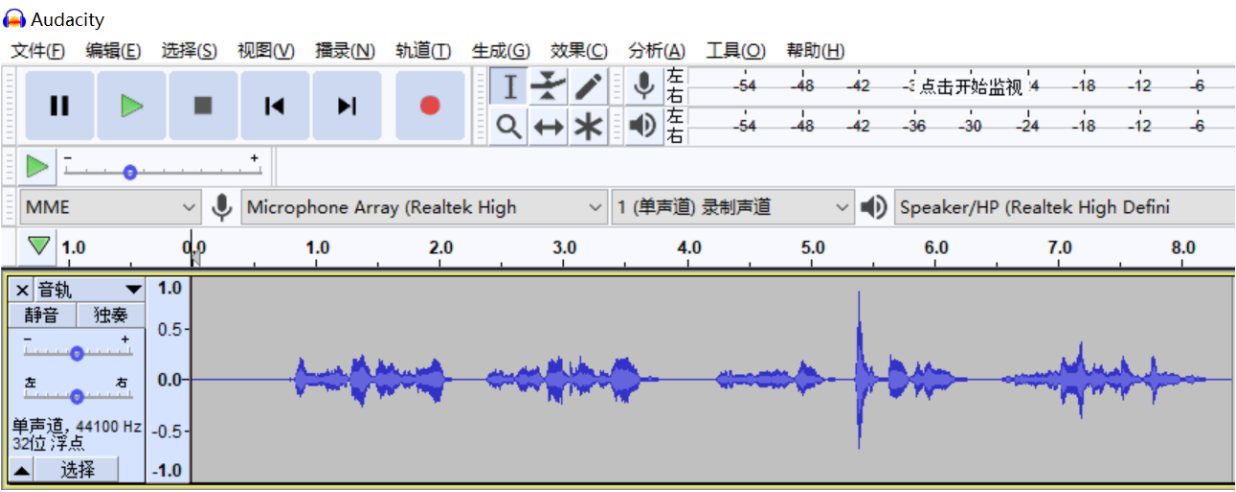

####  #2.2 制作数据清单：
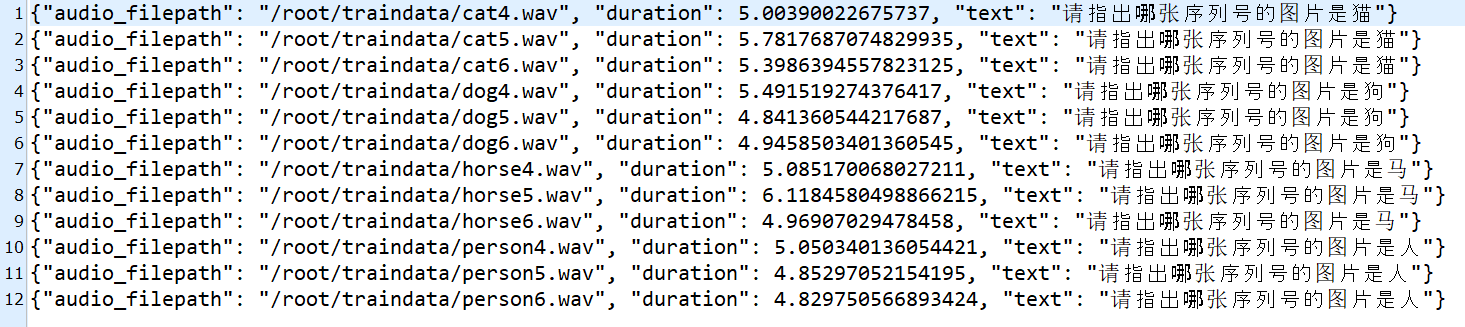

In [5]:
# 导入librosa音频工具包获取音频时长,用于制作语音数据集
import librosa 
time = librosa.get_duration(filename="/root/traindata/person10.wav")
print(time)

5.143219954648526


#### #2.3 加载数据清单

In [6]:
 #将制作好的json格式的数据清单加载进来
train_manifest = "/root/manifest/train_manifest.json"
test_manifest = "/root/manifest/test_manifest.json"

#### #2.4 加载quartznet配置文件

In [7]:
# 使用YAML读取quartznet模型配置文件
from ruamel_yaml import YAML 
config_path = "/root/config/quartznet_15x5_zh.yaml"

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'model': {'sample_rate': 16000, 'repeat': 5, 'dropout': 0.0, 'separable': True, 'labels': [' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '㶧', '䶮', '一', '丁', '七', '万', '丈', '三', '上', '下', '不', '与', '丐', '丑', '专', '且', '丕', '世', '丘', '丙', '业', '丛', '东', '丝', '丞', '丢', '两', '严', '丧', '个', '丫', '中', '丰', '串', '临', '丸', '丹', '为', '主', '丽', '举', '乃', '久', '么', '义', '之', '乌', '乍', '乎', '乏', '乐', '乒', '乓', '乔', '乖', '乘', '乙', '九', '乞', '也', '习', '乡', '书', '买', '乱', '乳', '乾', '了', '予', '争', '事', '二', '于', '亏', '云', '互', '五', '井', '亘', '亚', '些', '亟', '亡', '亢', '交', '亥', '亦', '产', '亨', '亩', '享', '京', '亭', '亮', '亲', '亳', '亵', '人', '亿', '什', '仁', '仄', '仅', '仆', '仇', '今', '介', '仍', '从', '仑', '仓', '仔', '仕', '他', '仗', '付', '仙', '仞', '仟', '仡', '代', '令', '以', '仨', '仪', '们', '仰', '仲', '件', '价', '任', '份', '仿', '企', '伉', '伊', '伍', '伎', '伏', '伐', '休', '众', '优', '伙', '会', '伞', '伟', '传', '伢'

#### #2.5 将数据清单传给配置文件

In [8]:
params['model']['train_ds']['manifest_filepath']=train_manifest
params['model']['validation_ds']['manifest_filepath']=test_manifest

#### #3.1 使用迁移学习的方法训练模型

In [9]:
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])# 指向我们将用于微调的数据作为训练集
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])# 指向新的验证数据进行微调
import pytorch_lightning as pl 
trainer = pl.Trainer(gpus=1,max_epochs=300)#重新设置训练器参数
trainer.fit(quartznet)#调用‘fit’方法开始训练 

[NeMo I 2021-11-10 09:17:15 collections:173] Dataset loaded with 28 files totalling 0.04 hours
[NeMo I 2021-11-10 09:17:15 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2021-11-10 09:17:18 collections:173] Dataset loaded with 4 files totalling 0.01 hours
[NeMo I 2021-11-10 09:17:18 collections:174] 0 files were filtered totalling 0.00 hours


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[NeMo W 2021-11-10 09:17:19 modelPT:436] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2021-11-10 09:17:19 modelPT:544] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )


[NeMo W 2021-11-10 09:17:19 lr_scheduler:604] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 5.3 M 
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     
------------------------------------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params
96.927    Total estimated model params size (MB)


[NeMo W 2021-11-10 09:17:26 nemo_logging:349] /root/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:376: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
      rank_zero_warn(
    
[NeMo W 2021-11-10 09:17:26 nemo_logging:349] /root/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
      rank_zero_warn(
    
[NeMo W 2021-11-10 09:17:27 nemo_logging:349] /root/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worke

#### #3.2 检验迁移学习训练模型的识别结果

In [10]:
print(quartznet.transcribe(paths2audio_files=["/root/testdata/horse_t.wav"]))


['请指出哪张序列号的图片是马']


#### 3.3模型的保存

In [14]:
quartznet.save_to("asr_model.nemo")# 将从头训练好的模型保存为.nemo格式

#### 3.4将训练好的模型进行重载

In [15]:
try_model_1 = nemo_asr.models.EncDecCTCModel.restore_from("asr_model.nemo")#对模型进行重新加载

[NeMo W 2021-11-06 20:34:51 modelPT:130] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /root/manifest/train_manifest.json
    sample_rate: 16000
    labels:
    - ' '
    - ''''
    - A
    - B
    - C
    - D
    - E
    - F
    - G
    - H
    - I
    - J
    - K
    - L
    - M
    - 'N'
    - O
    - P
    - Q
    - R
    - S
    - T
    - U
    - V
    - W
    - X
    - 'Y'
    - Z
    - 㶧
    - 䶮
    - 一
    - 丁
    - 七
    - 万
    - 丈
    - 三
    - 上
    - 下
    - 不
    - 与
    - 丐
    - 丑
    - 专
    - 且
    - 丕
    - 世
    - 丘
    - 丙
    - 业
    - 丛
    - 东
    - 丝
    - 丞
    - 丢
    - 两
    - 严
    - 丧
    - 个
    - 丫
    - 中
    - 丰
    - 串
    - 临
    - 丸
    - 丹
    - 为
    - 主
    - 丽
    - 举
    - 乃
    - 久
    - 么
    - 义
    - 之
    - 乌
    - 乍
    - 乎
    - 乏
    - 乐
    - 乒
    - 乓
    - 乔
    - 乖
    

[NeMo I 2021-11-06 20:34:51 features:262] PADDING: 16
[NeMo I 2021-11-06 20:34:51 features:279] STFT using torch
[NeMo I 2021-11-06 20:34:54 save_restore_connector:143] Model EncDecCTCModel was successfully restored from /root/asr_model.nemo.


#### 3.5 再次测试模型并完整打印推理识别结果

In [17]:
print(try_model_1.transcribe(paths2audio_files=[
                                                '/root/testdata/cat_t.wav',
                                                '/root/testdata/dog_t.wav',
                                                '/root/testdata/horse_t.wav',
                                                '/root/testdata/person_t.wav'],batch_size=4))


['请指出哪张序列号的图片是猫', '请指出哪张序列号的图是狗', '请指出哪张序列号的图片是人', '请指出哪张序列号的图片是人']


###  #4 成功拿到用于图像识别的语音指令
#### => 就可以作为Key关键字输入给计算机视觉模型进行交互在视频中或者图片里进行选择性检测 
#### 我们保存好经过验证的识别模型，为后续将模型移植部署在边缘计算设备Jetson Nano中做准备